## Install and import all libraries

In [18]:
!pip install --upgrade librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import os
import librosa
import sklearn
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder


## 1. Load Data from Google Drive

In [20]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [21]:
base_path = "/content/drive/My Drive/DS 5500"

folder_path = f'{base_path}/Data/genres_original'  # replace with your folder path
files = os.listdir(folder_path)

labels = []

for file in files:
    labels.append(file)

song_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/genres_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  song_dct[label] = files

images_dct = {}
for label in labels:
  folder_path = f'{base_path}/Data/images_original/{label}'  # replace with your folder path
  files = os.listdir(folder_path)
  images_dct[label] = files


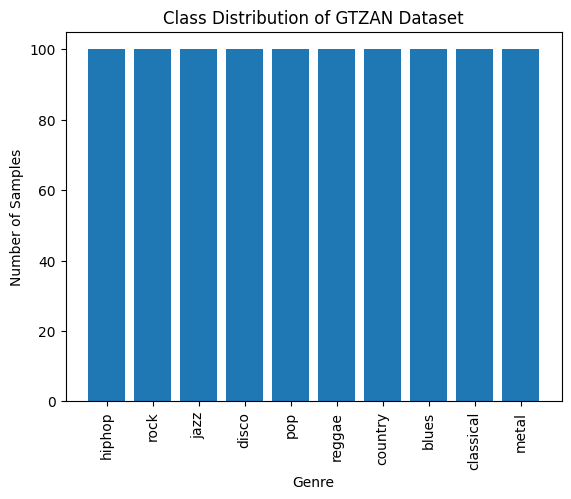

In [22]:
# Calculate the number of samples per genre
genre_counts = {genre: len(audio_files) for genre, audio_files in song_dct.items()}

# bar chart to visualize the class distribution
plt.bar(genre_counts.keys(), genre_counts.values())
plt.xlabel('Genre')
plt.ylabel('Number of Samples')
plt.title('Class Distribution of GTZAN Dataset')
plt.xticks(rotation=90)
plt.show()

## 2. Data Preprocessing

### 2.1 Convert to Spectrograms

### 2.2 Convert to MFCCs

Mel Frequency Cepstral Coefficients - MFCCs are derived from the short-term power spectrum of an audio signal and are used to represent the spectral characteristics of the signal in a compact form.

In [23]:
import math
mfcc_dict = {}
rejected_files = {}

#number of splits adds more training examples
splits = 10
#number of mfc coefficients
num_mfcc = 13
n_fft = 2048
hop_length = 512 #



for genre in song_dct.keys():
  audio_files = song_dct[genre]
  mfcc_dict[genre] = []
  for audio in audio_files:
    audio_file_path = f'{base_path}/Data/genres_original/{genre}/{audio}'

    try:
      # Load audio file
      y, sr = librosa.load(audio_file_path)

      sr = 22050 # changed from 22050 which is used more in speech recogniton
      track_samples = sr * 30
      samples_per_segment = int(track_samples / splits)
      num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

      for n in range(splits):
        start = samples_per_segment * n
        end = samples_per_segment * (n+1)
        mfcc = librosa.feature.mfcc(y = y[start:end],sr =sr, n_mfcc = num_mfcc,n_fft = n_fft, hop_length = hop_length)
        mfcc = mfcc.T

        if len(mfcc) == num_mfcc_vectors_per_segment:
          mfcc_dict[genre].append(mfcc)

    except Exception as e:
        print(f"Could not process file {audio_file_path}: {e}")
        if label in rejected_files:
            rejected_files[label].append(audio_file_path)
        else:
            rejected_files[label] = [audio_file_path]

<ipython-input-23-c1027e70ed45>:22: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_file_path)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process file /content/drive/My Drive/DS 5500/Data/genres_original/jazz/jazz.00054.wav: 


In [24]:
mfcc_dict.keys()

dict_keys(['hiphop', 'rock', 'jazz', 'disco', 'pop', 'reggae', 'country', 'blues', 'classical', 'metal'])

In [35]:

# set up X and Y from dict
X = []
y = []

# takes the labels and Mfccs and formats them into arrays
for genre, mfccs in mfcc_dict.items():
    for mfcc in mfccs:
        X.append(mfcc)
        y.append(genre)
print(np.array(X).shape)

# use np.stack instead of np.array for some reason this fixes an error later on
X = np.stack(X)
y = np.array(y)


(9986, 130, 13)


In [36]:
X.shape

(9986, 130, 13)

In [27]:
# # New addition
# X = (X - np.mean(X)) / np.std(X)

In [28]:
encoder = LabelEncoder()
y = to_categorical(encoder.fit_transform(y))

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# LSTM model
def create_model(input_shape):
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax')) # 10 genres in GTZAN dataset
    return model

input_shape = (X_train.shape[1], X_train.shape[2])
model = create_model(input_shape)

# Compile the model
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


In [ ]:
from keras.callbacks import EarlyStopping

# Specify the early stopping criteria
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# Train the model
history= model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                   callbacks = [early_stop])

# Save the model
model.save('baseline_LSTM.h5')


Epoch 1/100
100/100 [==============================] - 46s 413ms/step - loss: 1.9217 - accuracy: 0.3233 - val_loss: 1.5398 - val_accuracy: 0.4731
Epoch 2/100
100/100 [==============================] - 43s 431ms/step - loss: 1.6124 - accuracy: 0.4218 - val_loss: 1.4141 - val_accuracy: 0.5113
Epoch 3/100
100/100 [==============================] - 38s 382ms/step - loss: 1.4917 - accuracy: 0.4815 - val_loss: 1.3304 - val_accuracy: 0.5294
Epoch 4/100
100/100 [==============================] - 40s 403ms/step - loss: 1.3872 - accuracy: 0.5102 - val_loss: 1.2343 - val_accuracy: 0.5682
Epoch 5/100
100/100 [==============================] - 41s 406ms/step - loss: 1.3286 - accuracy: 0.5427 - val_loss: 1.2092 - val_accuracy: 0.5951
Epoch 6/100
100/100 [==============================] - 41s 412ms/step - loss: 1.3150 - accuracy: 0.5438 - val_loss: 1.2808 - val_accuracy: 0.5494
Epoch 7/100
100/100 [==============================] - 41s 408ms/step - loss: 1.2759 - accuracy: 0.5562 - val_loss: 1.1918 -

In [ ]:
# Plotting accuracy
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])

plt.show()


63/63 [==============================] - 10s 160ms/step


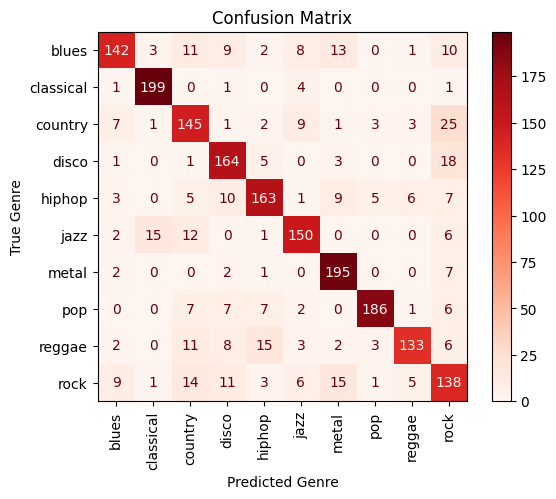

              precision    recall  f1-score   support

       blues       0.84      0.71      0.77       199
   classical       0.91      0.97      0.94       206
     country       0.70      0.74      0.72       197
       disco       0.77      0.85      0.81       192
      hiphop       0.82      0.78      0.80       209
        jazz       0.82      0.81      0.81       186
       metal       0.82      0.94      0.88       207
         pop       0.94      0.86      0.90       216
      reggae       0.89      0.73      0.80       183
        rock       0.62      0.68      0.65       203

    accuracy                           0.81      1998
   macro avg       0.81      0.81      0.81      1998
weighted avg       0.81      0.81      0.81      1998



In [34]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
import numpy as np



top_level_genres = encoder.classes_
# Assuming you have the model and the validation data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)


# Create confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=top_level_genres )

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Reds)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Genre')
plt.ylabel('True Genre')
# Rotate xticks vertically
plt.xticks(rotation='vertical')
plt.show()




# Generate classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=top_level_genres))



In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 130, 128)          72704     
                                                                 
 dropout_2 (Dropout)         (None, 130, 128)          0         
                                                                 
 lstm_3 (LSTM)               (None, 32)                20608     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 93,642
Trainable params: 93,642
Non-trainable params: 0
_________________________________________________________________


In [33]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))


63/63 [==============================] - 6s 96ms/step - loss: 0.6932 - accuracy: 0.8083
Accuracy: 80.83
